In [1]:
import h5py
import logging

import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from mayavi import mlab


In [2]:
logging.basicConfig(level = logging.DEBUG)
log = logging.getLogger(__name__)

In [3]:
# Constants

# Velocity of light in free space [m/s]
c = 2.9979e8
# Permittivity of free space [F/m]
e_0 = 8.854e-12
# Permeability of free space [H/m]
u_0 = 4 * np.pi * 1e-7
# Intrinsic impedance in free space [ohms]
z_0 = 120 * np.pi


In [4]:
def read_c_scan_freq(filename: str, polarization: str) -> np.ndarray:
    """Reads a .h5 file that contains the C-Scan and returns it in a ndarray

    Parameters
    ----------
    filename: str
        Filename of the .h5 file
    polarization: str
        Whether "x" or "y" polarization

    Returns
    -------
    ndarray
    Frequency ndarray C-Scan
    """
    data_frame = h5py.File(filename, 'r')
    f0 = data_frame['Frequency'].attrs['f0']
    ff = data_frame['Frequency'].attrs['ff']
    qf = int(data_frame['Frequency'].attrs['q'])
    # x- and y-axis lower limits, upper limits and step are retrieved
    x0 = data_frame['Position'].attrs['x0']
    dx = data_frame['Position'].attrs['dx']
    xf = data_frame['Position'].attrs['xf']
    y0 = data_frame['Position'].attrs['y0']
    dy = data_frame['Position'].attrs['dy']
    yf = data_frame['Position'].attrs['yf']
    log.debug(f"x: ({x0}, {xf})")
    log.debug(f"y: ({y0}, {yf})")
    log.debug(f"f: ({f0}, {ff})")
    # Amount of steps over each axis is calculated. Operation rounds up the division result as needed
    qx = int(round((xf - x0) / dx + 1))
    qy = int(round((yf - y0) / dy + 1))

    x = np.linspace(x0, xf, qx)
    y = np.linspace(y0, yf, qy)
    f = np.linspace(f0, ff, qf)

    c_scan = np.zeros([qx, qy, qf], dtype = 'complex_')

    for i in range(0, qx):
        # Indexes used to retrieve individual planes of the C-Scan are calculated
        index_0 = i * qy
        index_f = (i + 1) * qy
        c_scan[i, :, :] = data_frame[f'A-Scan/Re{{S21 {polarization}-pol}}'][index_0:index_f][:] + 1j*data_frame[f'A-Scan/Im{{S21 {polarization}-pol}}'][index_0:index_f][:]

    log.info(f"File {filename} read successfully")

    return c_scan, x, y, f

In [5]:
def vector_spectral_coefficient(k_x: np.ndarray, k_y: np.ndarray, omega: np.ndarray, e_r: np.ndarray, n: int = 0) -> np.ndarray:
    """Calculates vector spectral coefficient, F.

    Parameters
    ----------
    k_x: np.ndarray
        k_x-axis
    k_y: np.ndarray
        k_x-axis
    omega: np.ndarray
        Frequency of the
    e_r: np.ndarray
        Relative permittivities of each layer
    n: int
        Layer for calculation of vector spectral coefficient

    Returns
    -------
    ndarrray
    """
    # Depends on (kx, ky)
    k_rho_2 = k_x[:, np.newaxis]**2 + k_y[np.newaxis, :]**2
    # Free-space wavenumber (depends on omega)
    k_0 = omega / c
    # l-layer wavenumber (depends on omega and l)
    k = np.sqrt(e_r[np.newaxis, :])*k_0[:, np.newaxis]
    # l-layer dispersion relation (depends on kx, ky, omega, l)
    k_zl = np.sqrt(k[np.newaxis, np.newaxis, :, :]**2 - k_rho_2[:,:,np.newaxis, np.newaxis] + 0j)

    # Equ. (2.48b)
    T_TE = (2 * k_zl[:, :, :, :-1]) / (k_zl[:, :, :, :-1] + k_zl[:, :, :, 1:])
    # Equ. (2.48c)
    T_TM = (2 * e_r[np.newaxis, np.newaxis, np.newaxis, :-1] * k_zl[:, :, :, :-1]) / (e_r[np.newaxis, np.newaxis, np.newaxis, 1:] * k_zl[:, :, :, :-1] + e_r[np.newaxis, np.newaxis, np.newaxis, :-1] * k_zl[:, :, :, 1:])

    assert ((0 < T_TE) & (T_TE < 2)).all(), f"Fresnel transmission coefficient TE mode out of range (0, 1)"
    assert ((0 < T_TM) & (T_TM < 2)).all(), f"Fresnel transmission coefficient TM mode out of range (0, 1)"

    basis = np.eye(3)
    x_basis = basis[0]
    y_basis = basis[1]
    z_basis = basis[2]

    #idx_order = kx, ky, omega, vector component
    x_basis = x_basis[np.newaxis, np.newaxis, np.newaxis, :]
    y_basis = y_basis[np.newaxis, np.newaxis, np.newaxis, :]
    z_basis = z_basis[np.newaxis, np.newaxis, np.newaxis, :]

    k_x = k_x[:, np.newaxis, np.newaxis, np.newaxis]
    k_y = k_y[np.newaxis, :, np.newaxis, np.newaxis]
    k_n = k[np.newaxis, np.newaxis, :, n , np.newaxis]
    k_z0 = k_zl[:, :, :, 0, np.newaxis]
    k_zn = k_zl[:, :, :, n, np.newaxis]
    k_rho_2 = k_rho_2[:, :, np.newaxis, np.newaxis]

    F = (-x_basis * k_x * k_y + y_basis * k_x**2) / ( k_z0 * (k_rho_2)) * np.prod(T_TE[:,:,:,np.newaxis, :n], axis = -1) + k_y * k_zn * (x_basis * k_x * k_z0 + y_basis * k_y * k_z0 + z_basis * (k_rho_2))/(k_n**2 * k_z0 * (k_rho_2)) * np.prod(T_TM[:,:,:,np.newaxis, :n], axis = -1)

    return F

In [6]:
# Not used
def spectral_hertzian_dipole_radiation(x, y, omega, e_r, P_rad):
    # Rectangular to spherical
    x = np.linspace(0, 0.7, 141*2)
    y = np.linspace(0, 0.7, 141*2)
    rho = np.sqrt(x[:, np.newaxis]**2 + y[np.newaxis, :]**2 )
    theta = np.arctan2(y[np.newaxis, :], x[:, np.newaxis])

    # Free-space wavenumber (depends on omega)
    k_0 = omega / c
    lambda_f = c/np.max(omega)
    l = lambda_f * 1e-3
    # l-layer wavenumber (depends on omega and l)
    k = np.sqrt(1) * k_0
    R_r= z_0 * (2 * np.pi /3) * (l/lambda_f)**2
    I_0 = np.sqrt(2 * P_rad / R_r)
    print(f"Antenna Current: {I_0} A")


    electric_field = 1j * z_0 * (k[np.newaxis, np.newaxis, :] * I_0 * l * np.exp(-1j * k[np.newaxis, np.newaxis, :] * rho[:, :, np.newaxis]))/(4 * np.pi * (rho[:, :, np.newaxis]+1e-12)) * np.sin(theta[:, :, np.newaxis])

    radiated_field = np.abs(electric_field)

    spectral_radiated_field = np.fft.fft2(radiated_field, axes=(0, 1))

    spectral_radiated_field = np.fft.fftshift(spectral_radiated_field, axes=(0, 1))
    i_idx = 141//2+1
    f_idx = x.size - 141//2
    spectral_radiated_field = spectral_radiated_field[i_idx:f_idx, i_idx:f_idx, :]

    return spectral_radiated_field


In [7]:
def spectral_horn_radiation(k_x, k_y, omega):
    """Calculates the radiation pattern of a horn radiation in the spectral domain.

    Parameters
    ----------
    k_x: ndarray
    k_y: ndarray
    omega: ndarray

    Returns
    -------
    ndarray
        Spectral radiation of horn antenna.
    """
    k_0 = omega/c
    k_z0 = np.sqrt(k_0[np.newaxis, np.newaxis, :]**2 - k_x[:, np.newaxis, np.newaxis]**2 - k_y[np.newaxis, :, np.newaxis]**2)
    spectral_radiated_field = k_z0/k_0[np.newaxis, np.newaxis, :]
    return spectral_radiated_field

In [8]:
def udt(signal: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, f: np.ndarray, e_r: np.ndarray, thicknesses: np.ndarray) -> np.ndarray:
    """Migrates the frequency C-Scan using Uniform Diffraction Tomography (UDT) algorithm in stratified media.

    Parameters
    ----------
    signal: ndarray
        Frequency C-Scan (x, y, f)
    x: ndarray
        x-axis in signal
    y: ndarray
        y-axis in signal
    z: ndarray
        z-axis desired in migration
    f: ndarray
        f-axis in signal
    e_r: ndarray
        Relative permittivities of each layer
    thicknesses: ndarray
        Thicnesses of each layer

    Returns
    -------
    ndarray

    Migrated image (x, y, z)

    """
    n_layers = e_r.size
    print(f"Number of layers: {n_layers}")
    # Step 1
    signal_spectral = np.fft.fft2(signal, axes=(0, 1))
    signal_spectral = np.fft.fftshift(signal_spectral, axes=(0, 1))

    omega = 2 * np.pi * f

    d_x, d_y = x[1] - x[0], y[1] - y[0]
    k_x, k_y = np.fft.fftfreq(x.size, d = d_x) + 0j, np.fft.fftfreq(y.size, d = d_y) + 0j
    k_x[0], k_y[0] = -1e-12j, -1e-12j
    k_x, k_y = np.fft.fftshift(k_x) , np.fft.fftshift(k_y)

    # Free-space wavenumber (depends on omega)
    k_0 = omega / c
    # l-layer wavenumber (depends on omega and l)
    k = np.sqrt(e_r[np.newaxis, :])*k_0[:, np.newaxis]
    #
    k_z = np.sqrt(4*k[np.newaxis, np.newaxis, :, :] - k_x[:, np.newaxis, np.newaxis, np.newaxis]**2 - k_y[np.newaxis, :, np.newaxis, np.newaxis]**2 + 0j)
    # Step 2
    sigma_space = np.zeros((x.size, y.size, z.size), dtype=complex)
    z_idx = 0
    for n in range(n_layers):
        print(n)
        k_n = k[np.newaxis, np.newaxis, :, n]
        k_zn = k_z[:, :, :, n]
        #P = spectral_hertzian_dipole_radiation(x, y, omega, e_r[n], 0.001995262315)
        P = spectral_horn_radiation(k_x/2, k_y/2, omega)
        #P = 1
        F = vector_spectral_coefficient(k_x/2, k_y/2, omega, e_r, n)
        sigma_hat = (-z_0 * signal_spectral * np.exp(-1j*(k_zn * np.sum(thicknesses[0:n]) - np.sum(k_z[:,:,:,0:n]*thicknesses[np.newaxis, np.newaxis, np.newaxis, 0:n], axis = -1)))) / ( 8 * np.pi**3 * k_0[np.newaxis, np.newaxis, :] * P**2 * (np.linalg.norm(F, axis = -1))**2)

        z_i = 0 if n == 0 else thicknesses[n-1]
        z_f = np.sum(thicknesses[:n+1])
        for z_val in z[(z>=z_i) & (z<=z_f)]:
            print(f"Migrating z-slice [{z_idx}]: {z_val:.2f} m")
            z_val = np.maximum(z_val, 1e-12)
            first_term = (4 * k_n**2 * (z_val - np.sum(thicknesses[0:n]))**2)/(k_zn**4)
            second_term = (k**2 * thicknesses[np.newaxis,np.newaxis, np.newaxis, :]**2)/k_z**4
            third_term = (k[np.newaxis, np.newaxis, :, :]**2 * k_zn[:, :, :, np.newaxis]**2 + k_n[:, :, :, np.newaxis]**2 * k_z**2)/(k_z**3 * k_zn[:, :, :, np.newaxis]**3) * thicknesses[np.newaxis, np.newaxis, np.newaxis, :]

            k_s = k[np.newaxis, np.newaxis, :, :, np.newaxis]
            k_m = k[np.newaxis, np.newaxis, :, np.newaxis, :]
            k_zs = k_z[:, :, :, :, np.newaxis]
            k_zm = k_z[:, :, :, np.newaxis, :]
            t_s = thicknesses[np.newaxis, np.newaxis, np.newaxis, :, np.newaxis]
            t_m = thicknesses[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]
            fourth_term = (k_s**2 * k_zm**2 + k_m**2 * k_zs**2) / (k_zs**3 * k_zm**3) * t_s * t_m
            sum_mask = np.ones((n_layers,n_layers)) - np.eye(n_layers)
            sum_mask[n:,n:] = 0
            sum_mask = sum_mask.astype(bool)

            A_n = first_term + 4*np.sum(second_term[:,:,:,:n], axis=-1) + 4*np.sum(third_term[:,:,:,:n], axis=-1) * (z_val - np.sum(thicknesses[:n])) + np.sum(fourth_term, where = sum_mask, axis = (-1, -2))
            sigma_denominator = 1/(k_zn * (np.sqrt(A_n))) * (k_n**2/omega[np.newaxis, np.newaxis, :])
            sigma_denominator = np.trapz(sigma_denominator, k_x, axis=0)
            sigma_denominator = np.trapz(sigma_denominator, k_y, axis=0)

            sigma_numerator = np.fft.ifft2(np.fft.ifftshift(sigma_hat * np.exp(1j * k_zn * z_val)/k_zn, axes = (0, 1)) , axes = (0, 1))
            #sigma_numerator = np.fft.fftshift(sigma_numerator, axes = (0, 1))
            sigma_numerator = sigma_numerator * (k_n**2/omega[np.newaxis, np.newaxis, :])
            #log.debug(f"Sigma numerator shape: {sigma_numerator.shape}")
            #log.debug(f"Sigma denominator shape: {sigma_denominator.shape}")
            sigma_r = np.trapz(sigma_numerator/sigma_denominator[np.newaxis, np.newaxis, :], omega, axis=-1)
            sigma_space[:, :, z_idx] = sigma_r
            z_idx+=1

    return sigma_space

In [44]:
# Non-object scene
filename_0 = r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\01_solo_arena\01_merged_files\C_Scan_frequency_raw.h5"
# Buried object scene
filename = r"C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\08_placa_350_1350_esfera_200_1500\01_merged_files\C_Scan_default_title.h5"

c_scan_f_0, _, _, _ = read_c_scan_freq(filename_0, "x")
c_scan_f, x, y, f = read_c_scan_freq(filename, "x")


#z_1, z_2 = np.linspace(0, 0.79, 5, endpoint=False), np.linspace(0.79+1e-12, 0.79+0.26, 15)
#z = np.concatenate([z_1, z_2])
h_ant = 0.600 + 0.180
h_soil = 0.260
z = np.linspace(0, h_ant+h_soil, 25)
e_r = np.array([1, 2.58])
thicknesses = np.array([0.59, 0.46])


avg = np.mean(c_scan_f, axis = (0, 1))
mov_avg = ndimage.uniform_filter(c_scan_f, size=(25, 25, 1))

c_scan_f_sub = c_scan_f - c_scan_f_0
c_scan_f_avg = c_scan_f - avg
c_scan_f_mov_avg = c_scan_f - mov_avg

image = udt(c_scan_f_sub, x, y, z, f, e_r, thicknesses)

DEBUG:__main__:x: (0.0, 0.7)
DEBUG:__main__:y: (0.0, 0.7)
DEBUG:__main__:f: (600000000.0, 6000000000.0)
INFO:__main__:File C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\01_solo_arena\01_merged_files\C_Scan_frequency_raw.h5 read successfully
DEBUG:__main__:x: (0.0, 0.7)
DEBUG:__main__:y: (1.0, 1.7)
DEBUG:__main__:f: (600000000.0, 6000000000.0)
INFO:__main__:File C:\Users\leone\Universidad de los Andes\Daniel Julian Gonzalez Ramirez - Entrega Proyecto Desminado - Daniel Gonzalez\02 mediciones de gpr\08_placa_350_1350_esfera_200_1500\01_merged_files\C_Scan_default_title.h5 read successfully


Number of layers: 2
0
Migrating z-slice [0]: 0.00 m
Migrating z-slice [1]: 0.04 m
Migrating z-slice [2]: 0.09 m
Migrating z-slice [3]: 0.13 m
Migrating z-slice [4]: 0.17 m
Migrating z-slice [5]: 0.22 m
Migrating z-slice [6]: 0.26 m
Migrating z-slice [7]: 0.30 m
Migrating z-slice [8]: 0.35 m
Migrating z-slice [9]: 0.39 m
Migrating z-slice [10]: 0.43 m
Migrating z-slice [11]: 0.48 m
Migrating z-slice [12]: 0.52 m
Migrating z-slice [13]: 0.56 m
1
Migrating z-slice [14]: 0.61 m
Migrating z-slice [15]: 0.65 m
Migrating z-slice [16]: 0.69 m
Migrating z-slice [17]: 0.74 m
Migrating z-slice [18]: 0.78 m
Migrating z-slice [19]: 0.82 m
Migrating z-slice [20]: 0.87 m
Migrating z-slice [21]: 0.91 m
Migrating z-slice [22]: 0.95 m
Migrating z-slice [23]: 1.00 m
Migrating z-slice [24]: 1.04 m


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000222C2B7D400>
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000222C2D1E1C0>


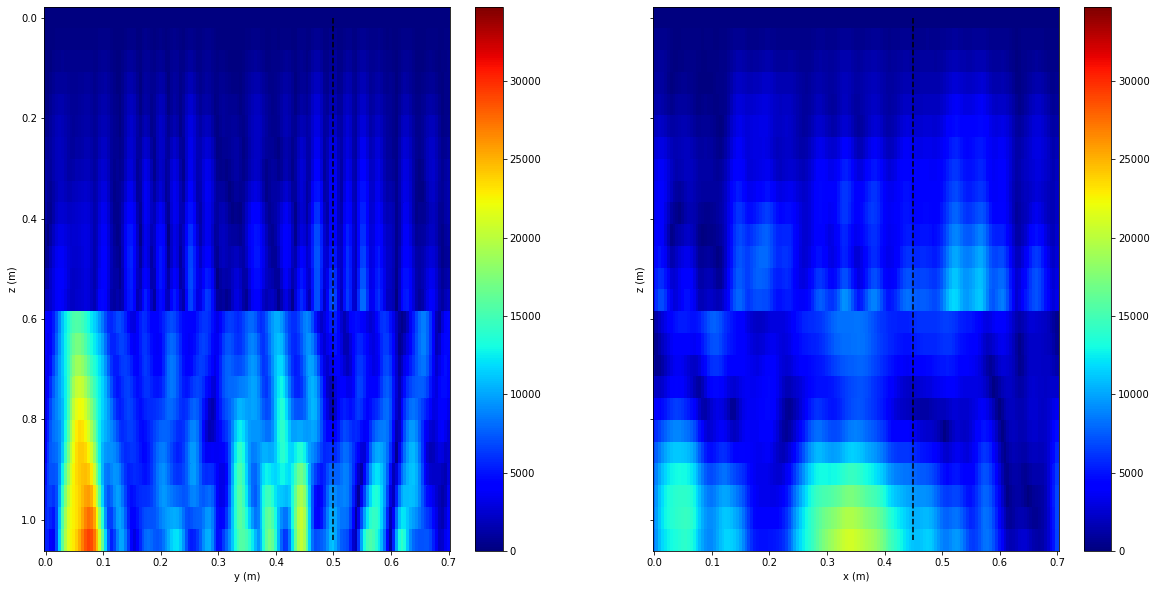

In [46]:
x_fixed = 0.450
x_fixed_idx = 90

y_fixed = 0.500
y_fixed_idx = 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10), sharey=True)
plot_1 = ax1.pcolor(x[:], z[:], np.swapaxes(np.abs(image[x_fixed_idx, :, :]), 0,1), cmap='jet', vmin = 0, vmax = np.max(np.abs(image)) )
ax1.plot(y_fixed*np.ones(z.size), z, "k--")
ax1.invert_yaxis()
ax1.set_ylabel("z (m)")
ax1.set_xlabel("y (m)")
fig.colorbar(plot_1, ax=ax1)

plot_2 = ax2.pcolor(x[:], z[:], np.swapaxes(np.abs(image[:, y_fixed_idx, :]), 0,1), cmap='jet', vmin = 0, vmax = np.max(np.abs(image)))
ax2.plot(x_fixed*np.ones(z.size), z, "k--")
ax2.set_ylabel("z (m)")
ax2.set_xlabel("x (m)")
fig.colorbar(plot_2, ax=ax2)

In [21]:
@mlab.show
def plot_migrated_image(image: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray):
    """Plot 3D migrated image

    Parameters
    ----------
    image: np.ndarray
        Migrated image
    x: np.ndarray
        x-axis
    y: np.ndarray
        y-axis
    z: np.ndarray
        z-axis

    Returns
    -------

    """
    # File is opened into data_frame variable
    #data_frame = h5py.File(migrated_image_file_name, 'r')
    # Title for the migrated image figure
    title = "UDT 3D-Migration"
    # x-, y- and z-axis lower limits, upper limits and amount of measurements are read
    x0, xf, qx = x[0], x[-1], x.size
    y0, yf, qy = y[0], y[-1], y.size
    z0, zf, qz = z[0], z[-1], z.size
    # Reads the migrated image
    mi = image
    # Data frame is closed
    #data_frame.close()
    # Grid with the domain points is created. Time axis is scaled to be within the same orders of magnitude as x and y.
    xg, yg, zg = np.mgrid[x0:xf:qx * 1j, y0:yf:qy * 1j, zf:z0:qz * 1j]
    #xg, yg, zg = np.meshgrid(x, y, z)

    #xg, yg, zg = xg.T, yg.T, zg.T
    # Labels for the horizontal and vertical axes are set
    x_label = 'x [m]'
    y_label = 'y [m]'
    v_label = 'z [m]'
    # Figure is created
    mlab.figure(figure=title, size=(1100, 800))
    # Volume slice type plot is added to the figure
    mlab.volume_slice(xg, yg, zg, mi, opacity=0.1, reset_zoom=True)
    # Options for the colorbar and axes are set
    cb1 = mlab.colorbar(orientation="vertical", nb_labels=5)
    cb1.scalar_bar.unconstrained_font_size = True
    cb1.label_text_property.font_size = 10
    cb1.label_text_property.bold = False
    cb1.label_text_property.italic = False
    ax = mlab.axes(xlabel=x_label, ylabel=y_label, zlabel=v_label)
    ax.label_text_property.font_size = 1
    ax.title_text_property.font_size = 1
    # Outline for the volume slice is added to the figure
    mlab.outline()
    # Title is added to the figure
    mlab.title(title, size=0.2, height=0)
    # Contour type plot is added to the figure
    mlab.contour3d(xg, yg, zg, mi, opacity=0.1, reset_zoom=True, contours=25)
    # Figure is displayed
    #mlab.show()

In [47]:
image_2 = image.copy()
image_2 = image_2[:, :, :]
image_avg = np.average(np.abs(image_2))
image_std = np.std(np.abs(image_2))
image_th = image_avg+1*image_std
image_modified_idx = np.abs(image_2) < image_th
image_2[image_modified_idx] = 0


In [48]:
plot_migrated_image(x, y, z[:], np.abs(image_2))

DEBUG:pyface.ui.qt4.gui:---------- starting GUI event loop ----------
DEBUG:mayavi.core.base:No view found for [<mayavi.core.scene.Scene object at 0x00000222E1726C70>] in [C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\mayavi\core\ui\scene.py]. Using the base class trait_view instead.
DEBUG:traitsui.editor_factory:Can't import toolkit_object 'rgb_color_editor:SimpleEditor': Can't import 'rgb_color_editor:SimpleEditor' for backend qt4
DEBUG:traitsui.editor_factory:Can't import toolkit_object 'rgb_color_editor:SimpleEditor': Can't import 'rgb_color_editor:SimpleEditor' for backend qt4
DEBUG:traitsui.editor_factory:Can't import toolkit_object 'compound_editor:ReadonlyEditor': Can't import 'compound_editor:ReadonlyEditor' for backend qt4
DEBUG:traitsui.editor_factory:Can't import toolkit_object 'compound_editor:ReadonlyEditor': Can't import 'compound_editor:ReadonlyEditor' for backend qt4
DEBUG:traitsui.editor_factory:Can't import toolkit_object 'compound_editor:ReadonlyEditor': 